In [79]:
import uproot
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cbook as cbook
import numpy as np
import pandas as pd
from decimal import Decimal
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy import stats
import landau
from scipy.interpolate import CubicSpline

In [80]:
savedir = "/sbnd/app/users/lnguyen/calib/plots/"
dosave=True

In [81]:
branches = [
    "meta.run",
    "meta.evt",
    "meta.iproc",
    "t0",
    "id",
    "clear_cosmic_muon",
    "start.x",
    "start.y",
    "start.z",
    "end.x",
    "end.y",
    "end.z",
    "dir.x",
    "dir.y",
    "dir.z",
    "hit_min_time_p2_tpcE",
    "hit_max_time_p2_tpcE",
    "hit_min_time_p2_tpcW",
    "hit_max_time_p2_tpcW"
]

In [82]:
fname = "/sbnd/app/users/lnguyen/calib/selection_v09_28_01/10kevents.root"
folderE = "caloskim"
tname = "TrackCaloSkim"

treeE = uproot.open(fname)[folderE][tname]
data = treeE.arrays(branches, library="pd")

In [83]:
# EXTERNAL INPUT: The drift window in TPC E and TPC W
tcathode_E = 2600
tcathode_W = 2600

# EXTERNAL INPUT: electron lifetime in TPC E and TPC W
electron_lifetime_tpcE = 10e3
electron_lifetime_tpcW = 10e3 #us

In [84]:
# CONFIG

a2c_dist = 200 # cm
tanode = 2600 # ticks
tick_period = 500 # ns
NTICKS = 3400 # ticks

In [85]:
ICARUS_AV = [    
    {
      "xmin": -200,
      "xmax": 0,
      "ymin": -200,
      "zmin": 0,
      "ymax": 200,
      "zmax": 500,
    },
    {
      "xmin": 0,
      "ymin": -200,
      "zmin": 0,
      "xmax": 200,
      "ymax": 200,
      "zmax": 500,
    }
]

ICARUS_FV = [{
        "xmin": ICARUS_AV[0]["xmin"] + 25,
        "ymin": ICARUS_AV[0]["ymin"] + 25,
        "zmin": ICARUS_AV[0]["zmin"] + 25,
        "xmax": ICARUS_AV[0]["xmax"] - 25,
        "ymax": ICARUS_AV[0]["ymax"] - 50,
        "zmax": ICARUS_AV[0]["zmax"] - 25,
    },
    {
        "xmin": ICARUS_AV[1]["xmin"] + 25,
        "ymin": ICARUS_AV[1]["ymin"] + 25,
        "zmin": ICARUS_AV[1]["zmin"] + 25,
        "xmax": ICARUS_AV[1]["xmax"] - 25,
        "ymax": ICARUS_AV[1]["ymax"] - 50,
        "zmax": ICARUS_AV[1]["zmax"] - 25,
    }
]

def InFV(xyz, FVs=ICARUS_FV):
    fids = []
    fid = xyz[0] == np.nan
    for fv in FVs:
        this_fid = [(xyz[i] > fv[p+"min"]) & (xyz[i] < fv[p+"max"]) for i, p in enumerate("xyz")]
        fid = fid | (this_fid[0] & this_fid[1] & this_fid[2])
    return fid

def InFVYZ(yz, FVs=ICARUS_FV):
    fids = []
    fid = yz[0] == np.nan
    for fv in FVs:
        this_fid = [(yz[i] > fv[p+"min"]) & (yz[i] < fv[p+"max"]) for i, p in enumerate("yz")]
        fid = fid | (this_fid[0] & this_fid[1])
    return fid

def isTPCE(df):
    return df.tpc <= 0

In [86]:
# use the external input to build the t0
ccross_t0_E = data.hit_max_time_p2_tpcE - tcathode_E
ccross_t0_W = data.hit_max_time_p2_tpcW - tcathode_W

data["ccross_t0"] = ((ccross_t0_E + ccross_t0_W) / 2.) * tick_period

has_t0 = True

In [87]:
ICARUS_FV_STOPPING = [{
        "xmin": ICARUS_AV[0]["xmin"] + 25,
        "ymin": ICARUS_AV[0]["ymin"] + 25,
        "zmin": ICARUS_AV[0]["zmin"] + 25,
        "xmax": ICARUS_AV[0]["xmax"] - 25,
        "ymax": ICARUS_AV[0]["ymax"] - 25,
        "zmax": ICARUS_AV[0]["zmax"] - 25,
    },
]

In [88]:
stopping_track = ~InFV([data["start.x"], data["start.y"], data["start.z"]]) &\
    InFV([data["end.x"], data["end.y"], data["end.z"]], ICARUS_FV_STOPPING) &\
    (data["dir.y"] < 0.) &\
    has_t0 &\
    (data.hit_min_time_p2_tpcE > 150) & (data.hit_max_time_p2_tpcE < NTICKS - 150) &\
    (data.hit_min_time_p2_tpcW > 150) & (data.hit_max_time_p2_tpcW < NTICKS - 150)
    #&\
    #(plane2_stopcalo.dqdx_corr.groupby("entry").first() / plane2_stopcalo.dqdx_corr.groupby("entry").last() > 2)

stopping_track.name="stopping"
stopping_track.index.name="entry"

stopping_track.sum() / stopping_track.size

0.023746383799421407

In [89]:
plane2branches = [
    "dqdx",
    "h.time",
    "h.tpc",
    "pitch",
    "h.width"
]
plane2branches = ["hits2.%s" % s for s in plane2branches]

In [90]:
plane2_stopcalo = treeE.arrays(["hits2.rr"], library="pd")#, entrystop=10000)
plane2_oncalo = ~np.isnan(plane2_stopcalo["hits2.rr"]) & (plane2_stopcalo["hits2.rr"] < 200) & (plane2_stopcalo["hits2.rr"] > 0.)
plane2_stopcalo = plane2_stopcalo[plane2_oncalo]

for b in plane2branches:
    bdf = treeE.arrays([b], library="pd")
    bdf = bdf[plane2_oncalo]
    plane2_stopcalo = plane2_stopcalo.merge(bdf, left_index=True, right_index=True, validate="one_to_one")
    del bdf


In [91]:
#plane2_stopcalo.columns = [s.split(".")[1] for s in plane2_stopcalo.columns]
plane2_stopcalo.rename(columns={'hits2.rr':'rr','hits2.dqdx':'dqdx','hits2.h.time':'time','hits2.h.tpc':'tpc','hits2.pitch':'pitch','hits2.h.width':'width'}, inplace=True)
plane2_stopcalo = plane2_stopcalo.sort_values(by=["entry", "rr"])

In [92]:
plane2_stopcalo["anisochronous"] = (np.abs(plane2_stopcalo.time.groupby("entry").diff(1)) > plane2_stopcalo.width) & (np.abs(plane2_stopcalo.time.groupby("entry").diff(-1)) > plane2_stopcalo.width)

In [93]:
# Guard bad dqdx, only save tracks for which we have a ccross t0
plane2_stopcalo = plane2_stopcalo[~np.isnan(plane2_stopcalo.dqdx)]
plane2_stopcalo = plane2_stopcalo.join(data.ccross_t0)
plane2_stopcalo = plane2_stopcalo[~np.isnan(plane2_stopcalo.ccross_t0)]

t0 = 0
def exp(t, *p):
    A,tau = p
    return A*np.exp(-(t - t0)/tau)

plane2_stopcalo["tpcE"] = isTPCE(plane2_stopcalo)
plane2_stopcalo.time = (plane2_stopcalo.time * tick_period - plane2_stopcalo.ccross_t0 - tanode*tick_period) / 1000.

plane2_stopcalo["dqdx_corr"] = plane2_stopcalo.dqdx * exp(plane2_stopcalo.time, 1., -electron_lifetime_tpcE)
plane2_stopcalo.loc[~plane2_stopcalo.tpcE, "dqdx_corr"] = plane2_stopcalo.dqdx[~plane2_stopcalo.tpcE] * exp(plane2_stopcalo.time[~plane2_stopcalo.tpcE], 1., -electron_lifetime_tpcW)

plane2_stopcalo = plane2_stopcalo.drop(columns="ccross_t0")


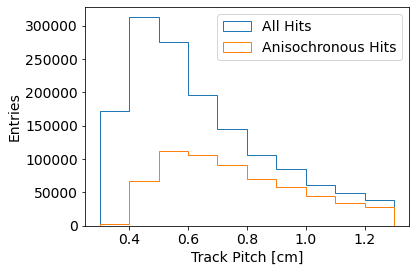

In [94]:
bins=np.linspace(0.3, 1.3, 11)
_,bins,_ = plt.hist(plane2_stopcalo.pitch, histtype="step", bins=bins, label="All Hits")
_ = plt.hist(plane2_stopcalo.pitch[plane2_stopcalo.anisochronous], histtype="step", bins=bins, label="Anisochronous Hits")
plt.ylabel("Entries")
plt.xlabel("Track Pitch [cm]")
plt.legend()
plt.tight_layout()
if dosave: plt.savefig(savedir + "pitch_anisochronous.png")

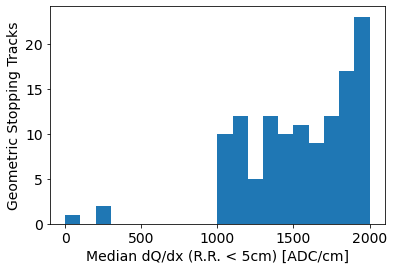

In [95]:
var = plane2_stopcalo.dqdx[plane2_stopcalo.rr < 5].groupby(level=0).median()
when = stopping_track
bins = np.linspace(0, 2000, 21)
_ = plt.hist(var[when], bins=bins)
plt.xlabel("Median dQ/dx (R.R. < 5cm) [ADC/cm]")
plt.ylabel("Geometric Stopping Tracks")

if dosave: plt.savefig(savedir + "median_dqdx_5cmrr_cutoff.png")

In [96]:
Rcut = 10 #cm
dqdxcut = 1.5e3
stopping_track_wcalo = stopping_track &\
    (plane2_stopcalo.dqdx[plane2_stopcalo.rr < 5].groupby(level=0).median() > dqdxcut)

#& (fitvar > 25) & (data.exp_fit_R < Rcut)

stopping_track_wcalo.name="stopping"
stopping_track_wcalo.index.name="entry"

print(stopping_track_wcalo.sum() / stopping_track_wcalo.size)
print(stopping_track_wcalo.sum())
print(stopping_track_wcalo.size)

0.01747830279652845
145
8296


In [97]:

if "stopping" in plane2_stopcalo.columns:
    plane2_stopcalo = plane2_stopcalo.drop(columns=["stopping"])

plane2_stopcalo = plane2_stopcalo.join(stopping_track_wcalo)

#plane2_stopcalo = plane2_stopcalo[plane2_stopcalo.stopping]
plane2_stopcalo = plane2_stopcalo.loc[plane2_stopcalo.stopping,:]

plane2_stopcalo = plane2_stopcalo.drop(columns=["stopping"])


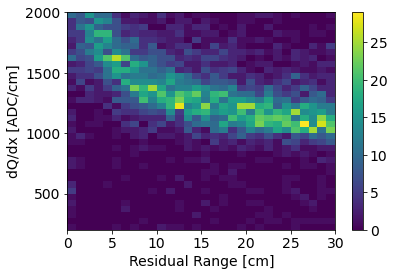

In [98]:
varx = plane2_stopcalo.rr
vary = plane2_stopcalo.dqdx_corr
when = plane2_stopcalo.tpcE
binx=np.linspace(0, 30, 31)
biny=np.linspace(200, 2000, 37)
_ = plt.hist2d(varx[when], vary[when], bins=[binx, biny])#, norm=colors.LogNorm())
plt.colorbar()
plt.xlabel("Residual Range [cm]")
plt.ylabel("dQ/dx [ADC/cm]")

#plt.text(0.3, 0.8, "dQ/dx cut: %.0f [ADC/cm]\nN Track: %i" % (dqdxcut, stopping_track_wcalo.sum()), transform=plt.gca().transAxes, fontsize=14, color="w")

if dosave: plt.savefig(savedir + "stoppping_dqdx_rr_zoom.png")

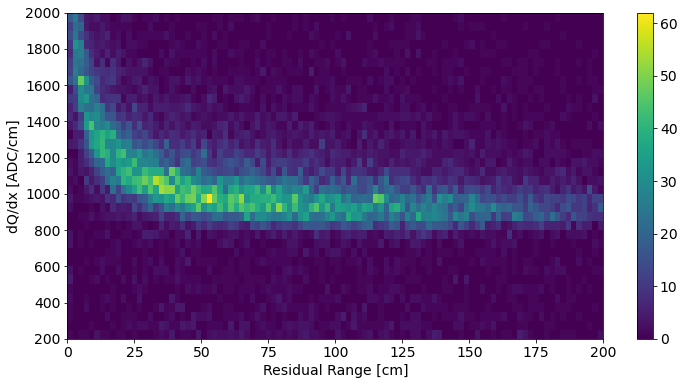

In [99]:
varx = plane2_stopcalo.rr
vary = plane2_stopcalo.dqdx_corr 
#when = plane2_stopcalo.tpcE | True
binx=np.linspace(0, 200, 101)
biny=np.linspace(200, 2000, 37)

plt.figure(figsize=(12, 6))
plt.rc("font", size=14)

_ = plt.hist2d(varx[when], vary[when], bins=[binx, biny])#, norm=colors.LogNorm())
plt.colorbar()
plt.xlabel("Residual Range [cm]")
plt.ylabel("dQ/dx [ADC/cm]")

#plt.text(0.3, 0.8, "dQ/dx cut: %.0f [ADC/cm]\nN Track: %i" % (dqdxcut, stopping_track_wcalo.sum()), transform=plt.gca().transAxes, fontsize=14, color="w")
if dosave: plt.savefig(savedir + "stoppping_dqdx_rr.png")

In [25]:
when_calibrate = (plane2_stopcalo.pitch < 0.8) & (plane2_stopcalo.pitch > 0.6) & (plane2_stopcalo.anisochronous)

0.6872971


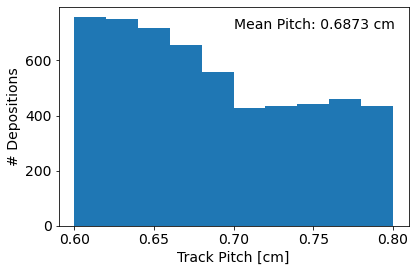

In [26]:
when = when_calibrate
_ = plt.hist(plane2_stopcalo.pitch[when])
MEAN_PITCH = np.mean(plane2_stopcalo.pitch[when])
print(MEAN_PITCH)
plt.xlabel("Track Pitch [cm]")
plt.ylabel("# Depositions")
plt.text(0.5, 0.9, "Mean Pitch: %.4f cm" % MEAN_PITCH, fontsize=14, transform=plt.gca().transAxes)
plt.tight_layout()
if dosave: plt.savefig(savedir + "pitches.png")

In [27]:
# From: https://pdg.lbl.gov/2012/AtomicNuclearProperties/MUON_ELOSS_TABLES/muonloss_289.pdf
LAr_density_gmL = 1.3973

CSDA_RR_REF = np.array([
    9.833e-1,
    1.786e0,
    3.321e0,
    6.598e0,
    1.058e1,
    3.084e1,
    4.250e1,
    6.732e1,
    1.063e2,
    1.725e2,
    2.385e2,
    4.934e2,
    6.163e2
]) / LAr_density_gmL

KE_REF = np.array([
    10.,
    14.,
    20.,
    30.,
    40.,
    80.,
    100.,
    140.,
    200.,
    300.,
    400.,
    800.,
    1000.
])

In [28]:
mass_electron = 0.5109989461 # MeV https://pdg.lbl.gov/2020/listings/rpp2020-list-K-plus-minus.pdf
mass = 105.6583745 # MeV https://pdg.lbl.gov/2020/listings/rpp2020-list-muon.pdf
Ival = 188.0e-6
Zval = 18.0
Aval = 39.948
Kfactor = 0.307075

def Calc_MPV_DEDX(pitch, T):
    gamma = (mass+T)/mass
    beta = pow(1.0-pow(gamma,-2.0),0.5)
    Wmax = (2.0*mass_electron*pow(beta,2.0)*pow(gamma,2.0))/(1.0+2.0*gamma*(mass_electron/mass)+pow(mass_electron/mass,2.0))

    # Medium energy 
    dens_factor = 2.0*np.log(10)*np.log10(beta*gamma)-5.2146+0.19559*pow(3.0-np.log10(beta*gamma),3.0)
    # low energy
    dens_factor[np.log10(beta*gamma) < 0.2] = 0.
    # high energy
    dens_factor[np.log10(beta*gamma) > 3.0] = (2.0*np.log(10)*np.log10(beta*gamma)-5.2146)[np.log10(beta*gamma) > 3.0]
    dEdx_mean = LAr_density_gmL*Kfactor*(Zval/Aval)*pow(beta,-2.0)*(0.5*np.log(2.0*mass_electron*pow(beta,2.0)*pow(gamma,2.0)*Wmax*pow(Ival,-2.0))-pow(beta,2.0)-dens_factor/2.0)
    xi = (Kfactor/2.0)*(Zval/Aval)*pow(beta,-2.0)*LAr_density_gmL*pitch
    kappa = xi/Wmax
    dEdx_MPV = xi*(np.log((2.0*mass_electron*pow(beta*gamma,2.0))/Ival)+np.log(xi/Ival)+0.200-pow(beta,2.0)-dens_factor)/pitch
  
    return dEdx_MPV

def Calc_MEAN_DEDX(T):
    gamma = (mass+T)/mass
    beta = pow(1.0-pow(gamma,-2.0),0.5)
    Wmax = (2.0*mass_electron*pow(beta,2.0)*pow(gamma,2.0))/(1.0+2.0*gamma*(mass_electron/mass)+pow(mass_electron/mass,2.0))

    # Medium energy 
    dens_factor = 2.0*np.log(10)*np.log10(beta*gamma)-5.2146+0.19559*pow(3.0-np.log10(beta*gamma),3.0)
    # low energy
    dens_factor[np.log10(beta*gamma) < 0.2] = 0.
    dens_factor[beta < 1e-6] = 0.
    # high energy
    dens_factor[np.log10(beta*gamma) > 3.0] = (2.0*np.log(10)*np.log10(beta*gamma)-5.2146)[np.log10(beta*gamma) > 3.0]
    dEdx_mean = LAr_density_gmL*Kfactor*(Zval/Aval)*pow(beta,-2.0)*(0.5*np.log(2.0*mass_electron*pow(beta,2.0)*pow(gamma,2.0)*Wmax*pow(Ival,-2.0))-pow(beta,2.0)-dens_factor/2.0)

    return dEdx_mean

In [29]:
KE_points_max = 1000.
dRR = 0.01
thisKE = KE_points_max

KE_points = [thisKE]
RR_points = [0.]

while thisKE > 0.0:
    deltaKE = Calc_MEAN_DEDX(np.array([thisKE])) * dRR
    RR_points.append(RR_points[-1] + dRR)
    thisKE -= deltaKE[0]
    KE_points.append(thisKE)
    
KE_points = np.array(list(reversed(KE_points[:-1])))
RR_points = np.array(RR_points[:-1])

In [30]:
MPV_dEDX_points = Calc_MPV_DEDX(MEAN_PITCH, KE_points)

RR2DEDX = CubicSpline(RR_points, MPV_dEDX_points)

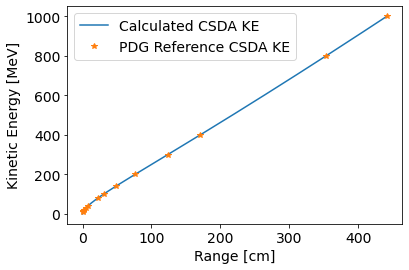

In [31]:
plt.plot(RR_points, KE_points, label="Calculated CSDA KE")
plt.plot(CSDA_RR_REF, KE_REF, "*", label="PDG Reference CSDA KE")
plt.legend()
plt.xlabel("Range [cm]")
plt.ylabel("Kinetic Energy [MeV]")

if dosave: plt.savefig(savedir + "range_KE_validation.png")

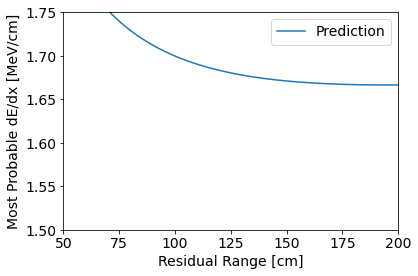

In [32]:
plt.plot(RR_points, MPV_dEDX_points, label="Prediction")
plt.ylim([1.5, 1.75])
plt.xlim([50, 200])
plt.xlabel("Residual Range [cm]")
plt.ylabel("Most Probable dE/dx [MeV/cm]")
plt.legend()

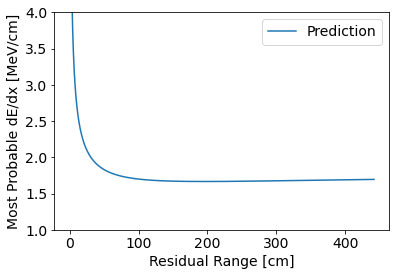

In [33]:
plt.plot(RR_points, MPV_dEDX_points, label="Prediction")
plt.ylim([1, 4])
plt.xlabel("Residual Range [cm]")
plt.ylabel("Most Probable dE/dx [MeV/cm]")
plt.legend()

if dosave: plt.savefig(savedir + "stopping_dEdx_prediction.png")

In [34]:
MODA = 0.930
MODB = 0.212
Wion = 1e3 / 4.237e7
Efield = 0.5

def recombination(dEdx):
    alpha = MODA
    beta = MODB / (LAr_density_gmL * Efield)
    
    dQdx = np.log(alpha + dEdx*beta) / (Wion * beta)
    return dQdx

In [35]:
def landau_gaus(X, *p):
    mpv, eta, sigma, A = p
    sigma = np.minimum(sigma, 100*eta)
    return landau.landau.gauss_landau(X, mpv, eta, sigma, A)

In [36]:
bins

array([   0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,
        900., 1000., 1100., 1200., 1300., 1400., 1500., 1600., 1700.,
       1800., 1900., 2000.])

In [37]:
rrs = np.linspace(50., 200., 31)
rrhis = rrs[1:]
rrlos = rrs[:-1]
RRs = (rrhis + rrlos)/2.
bins = np.linspace(200, 2000, 73)
bin_centers = (bins[1:] + bins[:-1]) / 2.

MPV_dqdxs = []

langau_params = []
langau_param_errs = []
for i,(rrlo, rrhi) in enumerate(zip(rrlos, rrhis)):
    #if i > 5: break
    when = when_calibrate &\
        (plane2_stopcalo.rr > rrlo) & (plane2_stopcalo.rr < rrhi)
    N,_ = np.histogram(plane2_stopcalo.dqdx_corr[when], bins=bins)
    
    p0 = [600, 30, 100, np.max(N)*40]
    
    # only fit near peak
    maxbin = np.argmax(N)
    when_fit = np.abs(np.array(range(len(bin_centers))) - maxbin) < 15 # within 10 bins
    
    popt, perr = curve_fit(landau_gaus, bin_centers[when_fit], N[when_fit], p0=p0, maxfev=10_000, sigma=np.maximum(np.sqrt(N),1)[when_fit])
    MPV_dqdxs.append(popt[0])
    langau_params.append(popt)
    langau_param_errs.append(perr)
    
MPV_dqdxs = np.array(MPV_dqdxs)

In [38]:
def langau_chi2(x, y, yerr, popt):
    return np.sum(((landau_gaus(x, *popt) - y) / yerr)**2)

/tmp/ipykernel_8190/2192193216.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(IND)


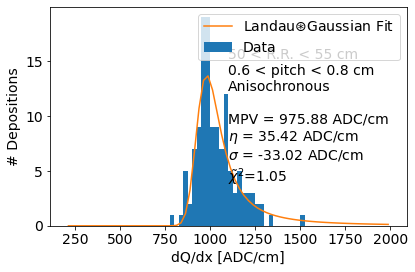

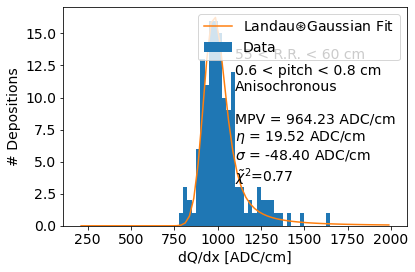

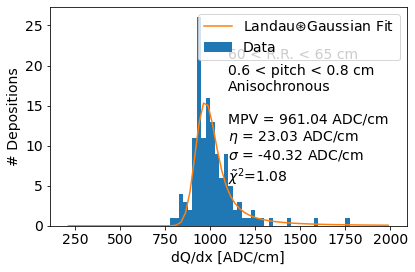

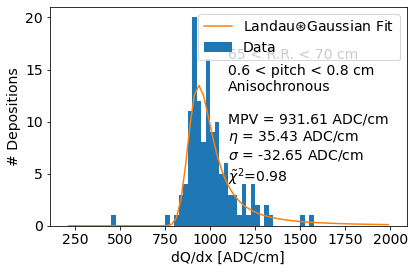

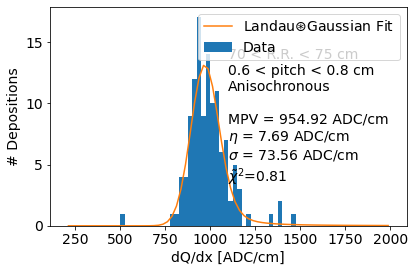

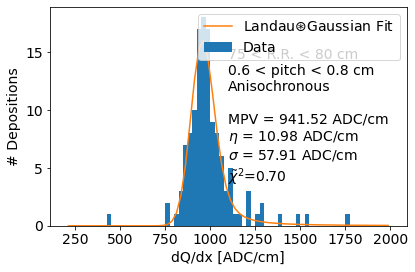

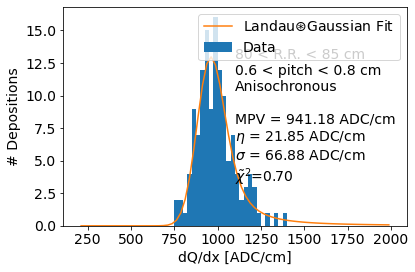

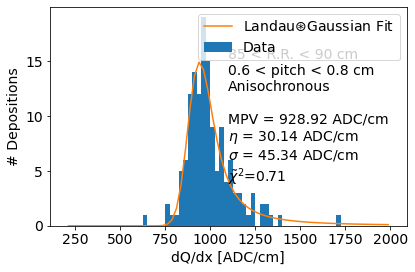

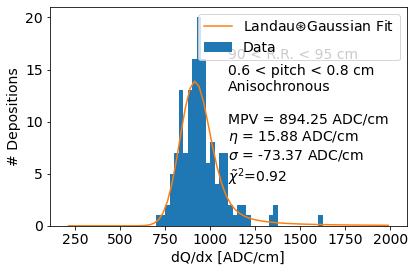

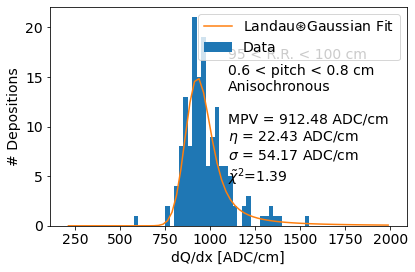

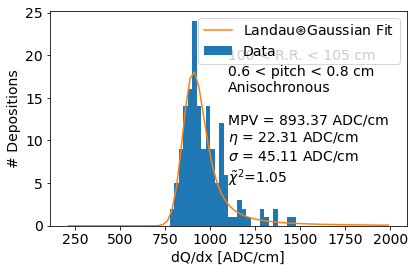

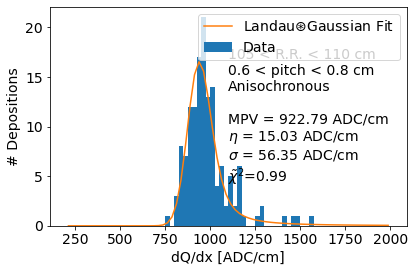

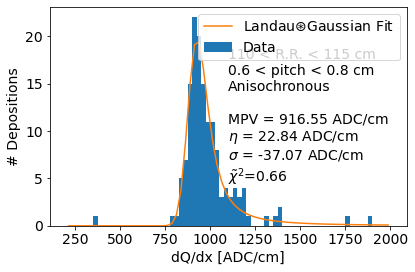

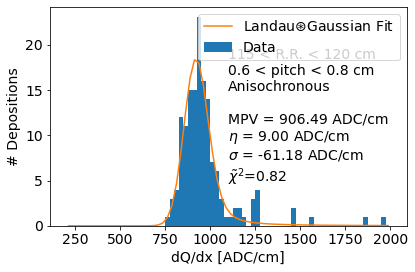

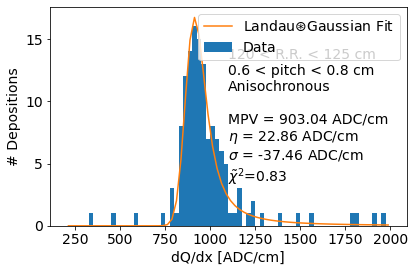

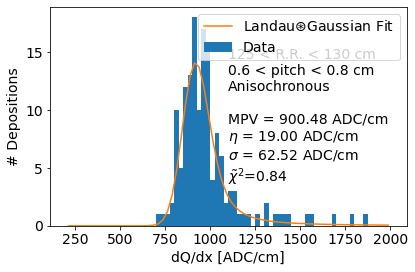

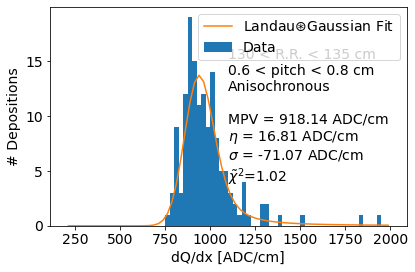

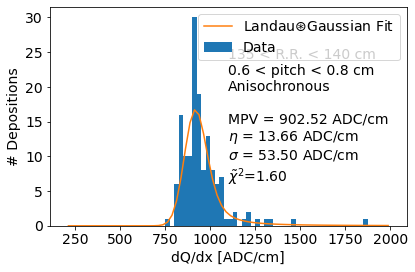

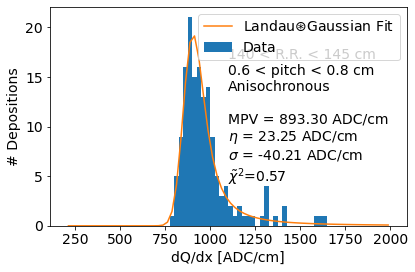

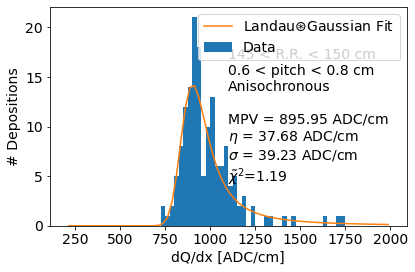

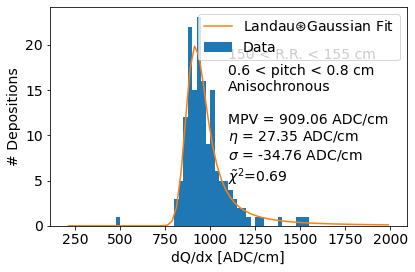

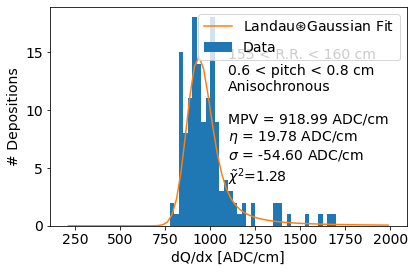

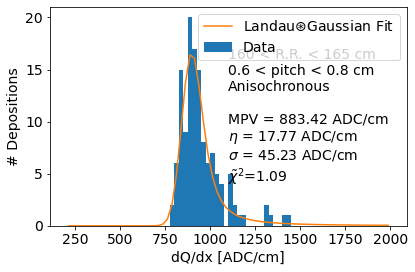

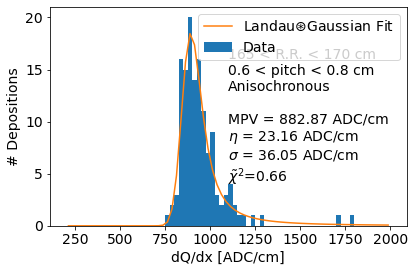

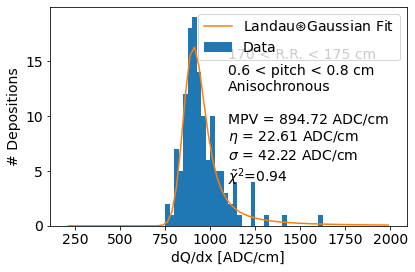

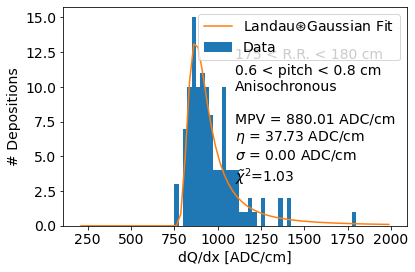

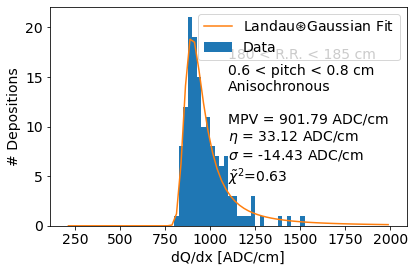

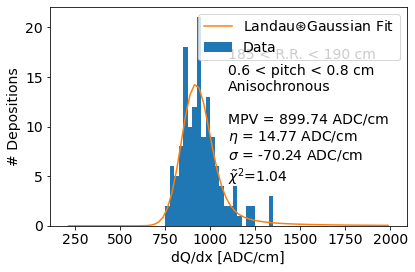

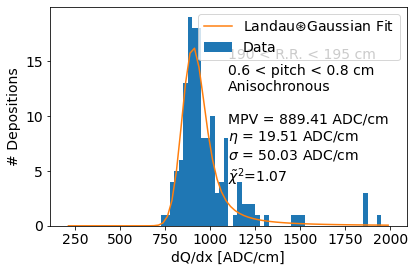

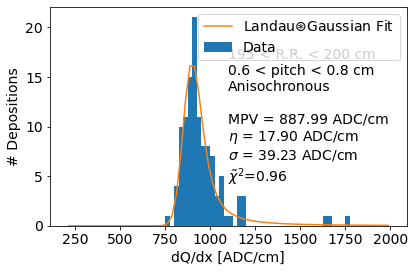

In [39]:
# Plot fits

for IND in range(len(RRs)):
    plt.figure(IND)
    when = when_calibrate &\
            (plane2_stopcalo.rr > rrlos[IND]) & (plane2_stopcalo.rr < rrhis[IND])
    
    N,_,_ = plt.hist(plane2_stopcalo.dqdx_corr[when], bins=bins, label="Data")
    chi2 = langau_chi2(bin_centers, N, np.maximum(np.sqrt(N), 1), langau_params[IND]) / (np.sum(N>0) -2)
    
    plt.plot(bin_centers, landau_gaus(bin_centers, *langau_params[IND]), label="Landau$\circledast$Gaussian Fit")
    plt.legend(fontsize=14)
    plt.text(0.5, 0.2, "%.0f < R.R. < %.0f cm\n0.6 < pitch < 0.8 cm\nAnisochronous\n\nMPV = %.2f ADC/cm\n$\eta$ = %.2f ADC/cm\n$\sigma$ = %.2f ADC/cm\n$\\tilde{\\chi}^2$=%.2f" % tuple([rrlos[IND], rrhis[IND]] + list(langau_params[IND][:3]) + [chi2]),
            fontsize=14, transform=plt.gca().transAxes)
    
    plt.xlabel("dQ/dx [ADC/cm]")
    plt.ylabel("# Depositions")
    plt.tight_layout()
    if dosave: plt.savefig(savedir + "dqdx_langau_fit_RR%.0f_%.0f_anisochronous.png" % (rrlos[IND], rrhis[IND]))

In [40]:
M = langau_param_errs[9]
D = np.diag(1./np.sqrt(np.diag(M)))

print(np.matmul(np.matmul(D,M), D))
print(np.diag(M)[0])

[[ 1.         -0.399726    0.47716906 -0.12386342]
 [-0.399726    1.         -0.74004974  0.36269653]
 [ 0.47716906 -0.74004974  1.         -0.20616457]
 [-0.12386342  0.36269653 -0.20616457  1.        ]]
93.55713615608747


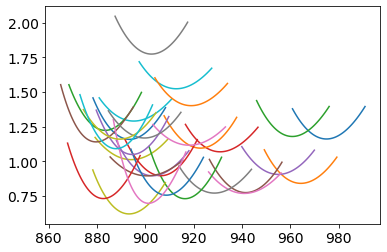

In [41]:
IND = 4
mpv_errs = []

for IND in range(len(RRs)):
    popt = langau_params[IND]
    central_mpv = popt[0]
    MPVs = np.linspace(popt[0] - 15, popt[0] + 15, 101)
    when = when_calibrate &\
            (plane2_stopcalo.rr > rrlos[IND]) & (plane2_stopcalo.rr < rrhis[IND])
    N,_ = np.histogram(plane2_stopcalo.dqdx_corr[when], bins=bins)

    chi2s = [langau_chi2(bin_centers, N, np.maximum(np.sqrt(N),1), [MPV] + list(popt[1:])) for MPV in MPVs]
    red_chi2s = np.array(chi2s) / (np.sum(N > 0) - 4)
    plt.plot(MPVs, red_chi2s)

    MPV_lo = MPVs[np.argmin(np.abs(red_chi2s - np.min(red_chi2s) - 1.)[MPVs < central_mpv])]
    MPV_hi = MPVs[MPVs > central_mpv][np.argmin(np.abs(red_chi2s - np.min(red_chi2s) - 1.)[MPVs > central_mpv])]
    
    mpv_errs.append((MPV_hi - MPV_lo) / 2.)


In [42]:
error = 0.005

#mpv_err = (error * MPV_dqdxs)
mpv_err = np.array([np.sqrt(np.diag(perr)[0]) for perr in langau_param_errs])
#mpv_err = np.array(mpv_errs)

In [43]:
def gain_predicted_MPV(CAL):
    dEdxs = RR2DEDX(RRs)
    dQdxs = recombination(dEdxs)
    return dQdxs / CAL

def gain_chi2(CAL):
    dEdxs = RR2DEDX(RRs)
    dQdxs = recombination(dEdxs)
    dQdxs_ADC = np.outer(1. / CAL, dQdxs)
    chi2s = (MPV_dqdxs - dQdxs_ADC)**2 / mpv_err**2
    return np.sum(chi2s, axis=-1)

In [44]:
cals = np.linspace(83.5, 87.5, 401)
red_chi2 = gain_chi2(cals) / (len(RRs) - 1)

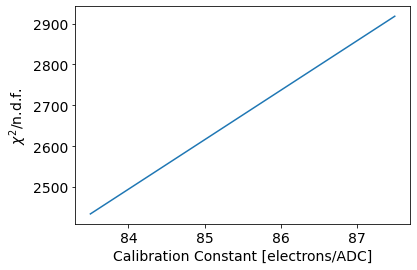

In [45]:
plt.plot(cals, red_chi2)
plt.xlabel("Calibration Constant [electrons/ADC]")
plt.ylabel(r'$\chi^2$/n.d.f.')
#plt.ylim([0, 10])
if dosave: plt.savefig(savedir + "calibration_constant_chi2_anisochronous.png")

In [46]:
BESTCAL = cals[np.argmin(red_chi2)]
print(BESTCAL, np.min(red_chi2))

CAL_MINUS = cals[np.argmin(np.abs(red_chi2 - np.min(red_chi2) - 1.)[cals < BESTCAL])]

CAL_PLUS = cals[cals > BESTCAL][np.argmin(np.abs(red_chi2 - np.min(red_chi2) - 1.)[cals > BESTCAL])]

print("%.2f + %.2f - %.2f" % (BESTCAL, abs(CAL_PLUS - BESTCAL), abs(CAL_MINUS-BESTCAL)))

83.5 2434.221606277715


ValueError: attempt to get argmin of an empty sequence

NameError: name 'CAL_PLUS' is not defined

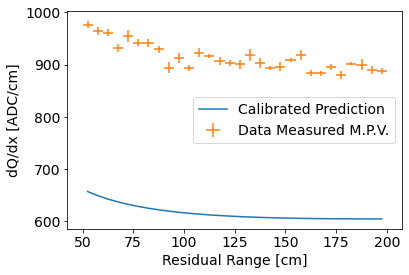

In [47]:
plt.plot(RRs, gain_predicted_MPV(BESTCAL), label="Calibrated Prediction")
plt.errorbar(RRs, MPV_dqdxs, yerr=mpv_err, xerr=2.5, ls="none", label="Data Measured M.P.V.")
plt.legend()
plt.xlabel("Residual Range [cm]")
plt.ylabel("dQ/dx [ADC/cm]")

plt.text(0.2, 0.6, "Calibration: $%.2f_{%.2f}^{%.2f}$ electrons/ADC"% (BESTCAL, abs(CAL_PLUS - BESTCAL), abs(CAL_MINUS-BESTCAL)),
        fontsize=14, transform=plt.gca().transAxes)

if dosave: plt.savefig(savedir + "calibrated_dQdx_predictionVdata_anisochronous.png")

In [ ]:
plt.plot(RRs, mpv_err)
plt.ylim([0, 20])

In [ ]:
langau_param_errs[8]

In [ ]:
np.diag(langau_param_errs[4])

In [ ]:
landau.landau.__dict__.keys()